## Debugging the `LabelModel` with deps + higher-order cliques

In [1]:
%matplotlib inline
import sys
sys.path.append("../") # go to parent dir

import numpy as np
import torch
import matplotlib.pyplot as plt
import mpmath

from synthetic.generate import SingleTaskTreeDepsGenerator
from metal.label_model import LabelModel
from metal.label_model.utils import (
    compute_mu,
    compute_covariance,
    compute_inv_covariance,
    print_matrix,
    visualize_matrix
)

### Generating a dataset

In [11]:
# Generate synthetic dataset
np.random.seed(2)
N = 10000
M = 10
K = 2
EDGE_PROB=1.0
data = SingleTaskTreeDepsGenerator(N, M, k=K, edge_prob=EDGE_PROB)



(0, 1)   [0.33264828 0.59158659]
(0, 2)   [0.46657705 0.25928616]
(1, 1)   [0.97266917 0.36731652]
(1, 2)   [0.35908193 0.20457399]
(2, 1)   [0.26355433 0.54486079]
(2, 2)   [0.60918862 0.29965165]
(3, 1)   [0.79074205 0.61957726]
(3, 2)   [0.25104098 0.43072423]
(4, 1)   [0.52180623 0.68883956]
(4, 2)   [0.81378077 0.69675561]
(5, 1)   [0.65172673 0.9917668 ]
(5, 2)   [0.20753632 0.23370831]
(6, 1)   [0.86705293 0.55857329]
(6, 2)   [0.29554293 0.99393967]
(7, 1)   [0.38376773 0.33285985]
(7, 2)   [0.82825776 0.41830784]
(8, 1)   [0.52105824 0.34675593]
(8, 2)   [0.81838035 0.83272457]
(9, 1)   [0.95328138 0.84059618]
(9, 2)   [0.56362521 0.29889834]
((0, 1), 1, 1)   [0.77196827 0.48838399]
((0, 1), 1, 2)   [0.89947337 0.94707397]
((0, 1), 2, 1)   [0.55271103 0.73183784]
((0, 1), 2, 2)   [0.73588781 0.53291958]
((0, 2), 1, 1)   [0.96428236 0.48342027]
((0, 2), 1, 2)   [0.39058679 0.785737  ]
((0, 2), 2, 1)   [0.93936571 0.74009552]
((0, 2), 2, 2)   [0.56568769 0.89602444]
((2, 3), 1, 

P(L_ 0 = 1 , L_ 8 = 2  | Y =  1 ) =  0.23867756245590704
P(L_ 0 = 2 , L_ 8 = 0  | Y =  1 ) =  0.04532994860427064
P(L_ 0 = 2 , L_ 8 = 1  | Y =  1 ) =  0.17399484695890716
P(L_ 0 = 2 , L_ 8 = 2  | Y =  1 ) =  0.24245650112895228
Labelers =  (0, 9)
P(L_ 0 = 0 , L_ 9 = 0  | Y =  1 ) =  0.011431199037769724
P(L_ 0 = 0 , L_ 9 = 1  | Y =  1 ) =  0.0448048747496073
P(L_ 0 = 0 , L_ 9 = 2  | Y =  1 ) =  0.02659911295182843
P(L_ 0 = 1 , L_ 9 = 0  | Y =  1 ) =  0.06284347339679035
P(L_ 0 = 1 , L_ 9 = 1  | Y =  1 ) =  0.24631128286640716
P(L_ 0 = 1 , L_ 9 = 2  | Y =  1 ) =  0.1462287603054669
P(L_ 0 = 2 , L_ 9 = 0  | Y =  1 ) =  0.06372553255111911
P(L_ 0 = 2 , L_ 9 = 1  | Y =  1 ) =  0.24977282705963594
P(L_ 0 = 2 , L_ 9 = 2  | Y =  1 ) =  0.14828293708137508
Labelers =  (1, 2)
P(L_ 1 = 0 , L_ 2 = 0  | Y =  1 ) =  0.0037646567573324775
P(L_ 1 = 0 , L_ 2 = 1  | Y =  1 ) =  0.0626663889045818
P(L_ 1 = 0 , L_ 2 = 2  | Y =  1 ) =  0.048120855192656534
P(L_ 1 = 1 , L_ 2 = 0  | Y =  1 ) =  0.0169469074

P(L_ 4 = 1 , L_ 8 = 0  | Y =  1 ) =  0.039262905025846014
P(L_ 4 = 1 , L_ 8 = 1  | Y =  1 ) =  0.1505152197980697
P(L_ 4 = 1 , L_ 8 = 2  | Y =  1 ) =  0.2094000589358417
P(L_ 4 = 2 , L_ 8 = 0  | Y =  1 ) =  0.052611944920862665
P(L_ 4 = 2 , L_ 8 = 1  | Y =  1 ) =  0.20165600630859543
P(L_ 4 = 2 , L_ 8 = 2  | Y =  1 ) =  0.28058449666696456
Labelers =  (4, 9)
P(L_ 4 = 0 , L_ 9 = 0  | Y =  1 ) =  0.009116864814921188
P(L_ 4 = 0 , L_ 9 = 1  | Y =  1 ) =  0.03567209205112023
P(L_ 4 = 0 , L_ 9 = 2  | Y =  1 ) =  0.021180411477778518
P(L_ 4 = 1 , L_ 9 = 0  | Y =  1 ) =  0.055084391546882924
P(L_ 4 = 1 , L_ 9 = 1  | Y =  1 ) =  0.21591252892848176
P(L_ 4 = 1 , L_ 9 = 2  | Y =  1 ) =  0.1281812632843927
P(L_ 4 = 2 , L_ 9 = 0  | Y =  1 ) =  0.07379894862387508
P(L_ 4 = 2 , L_ 9 = 1  | Y =  1 ) =  0.2893043636960484
P(L_ 4 = 2 , L_ 9 = 2  | Y =  1 ) =  0.17174913557649915
Labelers =  (5, 6)
P(L_ 5 = 0 , L_ 6 = 0  | Y =  1 ) =  0.01606577759432467
P(L_ 5 = 0 , L_ 6 = 1  | Y =  1 ) =  0.0902041101

P(L_ 1 = 1 , L_ 6 = 2  | Y =  2 ) =  0.21642863282281477
P(L_ 1 = 2 , L_ 6 = 0  | Y =  2 ) =  0.04866776088894469
P(L_ 1 = 2 , L_ 6 = 1  | Y =  2 ) =  0.15091316514753644
P(L_ 1 = 2 , L_ 6 = 2  | Y =  2 ) =  0.21495971287437324
Labelers =  (1, 7)
P(L_ 1 = 0 , L_ 7 = 0  | Y =  2 ) =  0.017605889541664626
P(L_ 1 = 0 , L_ 7 = 1  | Y =  2 ) =  0.06928082597595503
P(L_ 1 = 0 , L_ 7 = 2  | Y =  2 ) =  0.08119998307783388
P(L_ 1 = 1 , L_ 7 = 0  | Y =  2 ) =  0.0437215757279669
P(L_ 1 = 1 , L_ 7 = 1  | Y =  2 ) =  0.1720269353559863
P(L_ 1 = 1 , L_ 7 = 2  | Y =  2 ) =  0.20162415140973902
P(L_ 1 = 2 , L_ 7 = 0  | Y =  2 ) =  0.04345261091136037
P(L_ 1 = 2 , L_ 7 = 1  | Y =  2 ) =  0.17084660886169972
P(L_ 1 = 2 , L_ 7 = 2  | Y =  2 ) =  0.2002414191377944
Labelers =  (1, 8)
P(L_ 1 = 0 , L_ 8 = 0  | Y =  2 ) =  0.021570434047595795
P(L_ 1 = 0 , L_ 8 = 1  | Y =  2 ) =  0.07622119370420812
P(L_ 1 = 0 , L_ 8 = 2  | Y =  2 ) =  0.07029507084364964
P(L_ 1 = 1 , L_ 8 = 0  | Y =  2 ) =  0.053485284821

P(L_ 6 = 2 , L_ 7 = 1  | Y =  2 ) =  0.21372772794570055
P(L_ 6 = 2 , L_ 7 = 2  | Y =  2 ) =  0.2505053986652277
Labelers =  (6, 8)
P(L_ 6 = 0 , L_ 8 = 0  | Y =  2 ) =  0.015044528036088469
P(L_ 6 = 0 , L_ 8 = 1  | Y =  2 ) =  0.053216757064622616
P(L_ 6 = 0 , L_ 8 = 2  | Y =  2 ) =  0.049140067880221565
P(L_ 6 = 1 , L_ 8 = 0  | Y =  2 ) =  0.04665077634113666
P(L_ 6 = 1 , L_ 8 = 1  | Y =  2 ) =  0.16502794539409393
P(L_ 6 = 1 , L_ 8 = 2  | Y =  2 ) =  0.15237021417010885
P(L_ 6 = 2 , L_ 8 = 0  | Y =  2 ) =  0.0664501375190265
P(L_ 6 = 2 , L_ 8 = 1  | Y =  2 ) =  0.23507071172873698
P(L_ 6 = 2 , L_ 8 = 2  | Y =  2 ) =  0.21702886186596462
Labelers =  (6, 9)
P(L_ 6 = 0 , L_ 9 = 0  | Y =  2 ) =  0.015677821991432316
P(L_ 6 = 0 , L_ 9 = 1  | Y =  2 ) =  0.06699595372608577
P(L_ 6 = 0 , L_ 9 = 2  | Y =  2 ) =  0.034727577263414564
P(L_ 6 = 1 , L_ 9 = 0  | Y =  2 ) =  0.048610811720556465
P(L_ 6 = 1 , L_ 9 = 1  | Y =  2 ) =  0.2077549202795289
P(L_ 6 = 1 , L_ 9 = 2  | Y =  2 ) =  0.10768320

[(0, 1), (0, 2), (2, 3), (3, 4), (2, 5), (4, 6), (3, 7), (2, 8), (7, 9)]


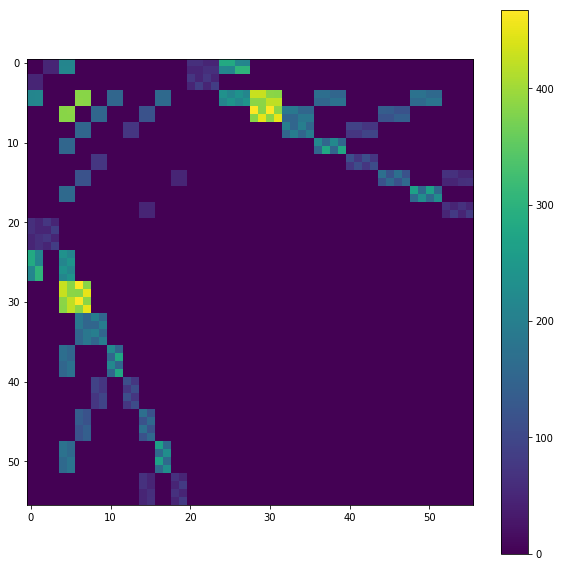

In [12]:
# mask the diagonals so we don't get influenced by them unfairly
sg_no_diag = np.copy(data.sig_inv)
for i in range(M):
    sg_no_diag[i*2:i*2+2,i*2:i*2+2] = np.zeros([2,2])
for j in range(M-1):
    sg_no_diag[2*M+j*4:2*M+j*4+4,2*M+j*4:2*M+j*4+4] = np.zeros([4,4])

print(data.E)
visualize_matrix(np.abs(sg_no_diag))

### Training the `LabelModel`

Note that:
* The `train` method assembles other data structures, such as the dependencies junction tree, etc.
* The `higher_order_cliques` kwarg controls whether or not to include them

In [4]:
lm = LabelModel(k=data.k, class_balance=data.p)

In [5]:
lm.config['higher_order_cliques'] = True

In [6]:
'''# Generate the "correct" mu
lm._set_constants(data.L)
lm._set_dependencies(data.E)
mu = compute_mu(lm._get_augmented_label_matrix(data.L.todense()), data.Y, K, data.p)

# Compute O, O_inv, P based on L
lm._generate_O(data.L.todense())
O = lm.O.numpy()
print(O)
d, d = O.shape
O_inv = np.linalg.inv(O)
P = np.diag(data.p)

JJT = np.linalg.inv(np.linalg.inv(P) - mu.T @ O_inv @ mu)
ZZT = O_inv @ mu @ JJT @ mu.T @ O_inv.T'''
print('temporarily commented out')

temporarily commented out


In [7]:
# Check that JJT is indeed PSD ==> ZZT is rank k
#np.linalg.eig(JJT)[0]

In [8]:
#np.linalg.eig((ZZT + ZZT.T)/2)[0]

In [9]:
lm.train(
    data.L,
    deps=data.E,
    all_unary_cliques=True,
    higher_order_cliques=True,
    n_epochs=50000,
    print_every=5000,
    lr=0.0001,
    l2=0,
    O_inv_prec=1024,
    #O_inv=ZZT
)

lm._set_constants(data.L)
lm._set_dependencies(data.E)
mu = compute_mu(lm._get_augmented_label_matrix(data.L.todense()), data.Y, K, data.p)


# Test against the true parameter values
mu_est = lm.mu.detach().numpy()
print(f"Average absolute error: {np.mean(np.abs(mu_est - mu))}")

Computing O^{-1}...
Estimating Z...
[Epoch 0] Loss: 1265079.375000
[Epoch 5000] Loss: 14751.180664
[Epoch 10000] Loss: 14723.509766
[Epoch 15000] Loss: 14711.140625
[Epoch 20000] Loss: 14752.640625
[Epoch 25000] Loss: 14704.625000
[Epoch 30000] Loss: 14703.866211
[Epoch 35000] Loss: 14705.026367
[Epoch 40000] Loss: 14704.472656
[Epoch 45000] Loss: 14703.853516
[Epoch 49999] Loss: 14705.061523
Estimating \mu...
[Epoch 0] Loss: 1047.384521
[Epoch 5000] Loss: 0.000375
[Epoch 10000] Loss: 0.000089
[Epoch 15000] Loss: 0.000040
[Epoch 20000] Loss: 0.000022
[Epoch 25000] Loss: 0.000017
[Epoch 30000] Loss: 0.000014
[Epoch 35000] Loss: 0.000014
[Epoch 40000] Loss: 0.000013
[Epoch 45000] Loss: 0.000013
[Epoch 49999] Loss: 0.000013
Average absolute error: 0.06950499439287791


### Sanity check that the true $Z$ gets lower loss

In [10]:
sorted(np.linalg.eig(O)[0])[::-1]

NameError: name 'O' is not defined

In [ ]:
O = lm.O.numpy()
d, d = O.shape
O_inv = lm.O_inv.numpy()
mask = lm.mask.numpy()
P = lm.P.numpy()

JJT = np.linalg.inv(np.linalg.inv(P) - mu.T @ O_inv @ mu)
ZZT = O_inv @ mu @ JJT @ mu.T @ O_inv.T

np.linalg.norm((O_inv + ZZT) * mask)**2

#### Seed=2

In [ ]:
visualize_matrix(mask)

In [ ]:
#visualize_matrix(np.abs((O_inv + ZZT) * mask))

In [ ]:
lm.c_data

In [ ]:
Z_est = lm.Z.detach().numpy()
visualize_matrix(np.abs((O_inv + Z_est @ Z_est.T) * mask))

#### Seed=1

In [ ]:
visualize_matrix(mask)

In [ ]:
visualize_matrix(np.abs((O_inv + ZZT) * mask))

In [ ]:
Z_est = lm.Z.detach().numpy()
visualize_matrix(np.abs((O_inv + Z_est @ Z_est.T) * mask))

#### Seed=0

In [ ]:
visualize_matrix(mask)

In [ ]:
visualize_matrix(np.abs((O_inv + ZZT) * mask))

In [ ]:
Z_est = lm.Z.detach().numpy()
visualize_matrix(np.abs((O_inv + Z_est @ Z_est.T) * mask))

### Visualizing matrices

In [ ]:
visualize_matrix(np.abs(mu_est - mu))

In [ ]:
visualize_matrix(np.abs(mu_est - mu))

In [ ]:
lm.c_data

In [ ]:
data.E

### Trying to solve with `scipy.optimize.minimize`

In [ ]:
from scipy.optimize import minimize

O_inv = lm.O_inv.numpy()
mask = lm.mask.numpy()

z0 = np.random.randn(lm.d * lm.k)
l import LabelModl import LabelModel
from metal.label_model.utils import (
    compute_mu,
    compute_covariance,
    compute_inv_covariance,
    print_matrix,el
from metal.label_model.utils import (
    compute_mu,
    compute_covariance,
    compute_inv_covariance,
    print_matrix,
def objective_fn(z):
    Z = z.reshape(-1, data.k)
    return np.linalg.norm( (O_inv + Z @ Z.T) * mask )**2

def gradient_fn(z):
    Z = z.reshape(-1, data.k)
    X = (O_inv + Z @ Z.T) * mask
    return np.ravel(X @ Z)

res = minimize(objective_fn, z0, jac=gradient_fn, method='BFGS')
Z = res['x'].reshape(-1, data.k)
res['fun']

In [ ]:
O = lm.O.numpy()
P = lm.P.numpy()
I_k = np.eye(data.k)
Q = O @ Z @ np.linalg.inv(I_k + Z.T @ O @ Z) @ Z.T @ O

mu0 = np.random.randn(lm.d * lm.k)

def objective_fn_2(mu):
    M = mu.reshape(-1, data.k)
    return np.linalg.norm(Q - M @ P @ M.T)**2 + np.linalg.norm(np.sum(M @ P, 1) - np.diag(O))**2

res_2 = minimize(objective_fn_2, mu0, method='BFGS')
M = res_2['x'].reshape(-1, data.k)
res_2['fun']

In [ ]:
# Test against the true parameter values
print(f"Average absolute error: {np.mean(np.abs(M - mu))}")

## Visualizing the inverse covariance matrix

In [ ]:
J = compute_inv_covariance(
    lm._get_augmented_label_matrix(data.L.todense()),
    data.Y,
    data.k,
    data.p
)
visualize_matrix(np.abs(J))

In [ ]:
visualize_matrix(lm.mask.numpy(), fig_size=[5,5])

In [ ]:
O_inv = lm.O_inv.numpy()
Z = lm.Z.detach().numpy()
mask = lm.mask.numpy()
visualize_matrix(np.abs((O_inv + Z@Z.T) * mask))

### Looking at the internal 'bookkeeping' of cliques...

In [ ]:
lm.c_data

In [ ]:
# Dependency edge weights
[((i,j), data.theta[(i,j)]) for i,j in data.E]